In [27]:
import pandas as pd

data_path = r'C:\Users\lyq09mow\Data\Kaiserslautern\kaiserslautern-de\sample_locations_raster_25km.csv'
coords_df = pd.read_csv(data_path)

print(coords_df.head())  # To confirm data is loaded correctly


   grid-i  grid-j       lon        lat     class
0       0      28  7.262759  49.423130  Airports
1       0      29  7.262759  49.427022  Airports
2       0      30  7.262759  49.430914  Airports
3       0      31  7.262759  49.434806  Airports
4       1      30  7.270189  49.430914  Airports


In [14]:
import os
import requests
import pandas as pd
from PIL import Image as PILImage
import io
from IPython.display import Image as IPyImage, display


    
def save_images(coords_df, api_key, folder=r'C:\Users\lyq09mow\ModelImages\Predictions\kaiserslautern'):
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    # Initialize a counter to track the number of API calls
    api_call_count = 0

    for index, row in coords_df.iterrows():
        # Fetch image data from Google Maps API
        image_data = fetch_image(row['lat'], row['lon'], api_key)
        api_call_count += 1  # Increment the API call counter

        if image_data:
            # Construct filename as 'grid-i_grid-j_lat_lon.png'
            filename = f'{int(row["grid-i"])}_{int(row["grid-j"])}_{row["lat"]}_{row["lon"]}.png'
            file_path = os.path.join(folder, filename)
            with open(file_path, 'wb') as file:
                file.write(image_data)
            
            print(f"API call count: {api_call_count} / {coords_df.shape[0]}")
            print(f"Saved: {file_path}")

            # Every 100 API calls, log the progress and show the last fetched image
            if api_call_count % 100 == 0:
                print(f"API calls so far: {api_call_count}")
                # display(IPyImage(data=image_data))
        else:
            print(f"Failed to fetch image for index {index}")

def fetch_image(lat, lon, api_key, zoom=17, size='224x224', maptype='satellite'):
    """Fetches an image from Google Static Maps API."""
    base_url = "https://maps.googleapis.com/maps/api/staticmap?"
    params = {
        'center': f'{lat},{lon}',
        'zoom': zoom,
        'size': size,
        'maptype': maptype,
        'key': api_key
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        return response.content
    else:
        print("Error fetching image:", response.status_code, response.text)
        return None


# Usage
api_key = 'API_Key'  
excel_path = r'C:\Users\lyq09mow\Data\Kaiserslautern\kaiserslautern-de\sample_locations_raster_25km.csv'  
coords_df = pd.read_csv(excel_path)  

save_images(coords_df, api_key)


API call count: 1 / 4566
Saved: C:\Users\lyq09mow\ModelImages\Predictions\kaiserslautern\0_28_49.42313035357215_7.262759044166749.png
API call count: 2 / 4566
Saved: C:\Users\lyq09mow\ModelImages\Predictions\kaiserslautern\0_29_49.42702225680131_7.262759044166749.png
API call count: 3 / 4566
Saved: C:\Users\lyq09mow\ModelImages\Predictions\kaiserslautern\0_30_49.43091416003045_7.262759044166749.png
API call count: 4 / 4566
Saved: C:\Users\lyq09mow\ModelImages\Predictions\kaiserslautern\0_31_49.43480606325962_7.262759044166749.png
API call count: 5 / 4566
Saved: C:\Users\lyq09mow\ModelImages\Predictions\kaiserslautern\1_30_49.43091416003045_7.270188782807931.png
API call count: 6 / 4566
Saved: C:\Users\lyq09mow\ModelImages\Predictions\kaiserslautern\1_31_49.43480606325962_7.270188782807931.png
API call count: 7 / 4566
Saved: C:\Users\lyq09mow\ModelImages\Predictions\kaiserslautern\1_32_49.43869796648877_7.270188782807931.png
API call count: 8 / 4566
Saved: C:\Users\lyq09mow\ModelImages\

In [28]:
import pandas as pd
import numpy as np

# Path to your CSV file with grid information
csv_path = data_path
grid_df = pd.read_csv(csv_path)


In [47]:
selected_classes = [
    'Airports',
    'Fast transit roads and associated land',
    'Forests',
    'Green urban areas',
    'Industrial, commercial, public, military and private units',
    'Land without current use',
    'Railways and associated land',
    'Sports and leisure facilities',
    'Urban Fabric',
    'Water'
]

# Create mappings
class2label = {c: i for i, c in enumerate(selected_classes)}
label2class = {i: c for i, c in enumerate(selected_classes)}

print(class2label)
print(label2class)


{'Airports': 0, 'Fast transit roads and associated land': 1, 'Forests': 2, 'Green urban areas': 3, 'Industrial, commercial, public, military and private units': 4, 'Land without current use': 5, 'Railways and associated land': 6, 'Sports and leisure facilities': 7, 'Urban Fabric': 8, 'Water': 9}
{0: 'Airports', 1: 'Fast transit roads and associated land', 2: 'Forests', 3: 'Green urban areas', 4: 'Industrial, commercial, public, military and private units', 5: 'Land without current use', 6: 'Railways and associated land', 7: 'Sports and leisure facilities', 8: 'Urban Fabric', 9: 'Water'}


In [29]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img_path, target_size=(224, 224)):
    datagen = ImageDataGenerator(rescale=1./255)  # Rescale as an example
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = datagen.standardize(img_array)
    return img_array


In [30]:
from tensorflow.keras.models import load_model

model = load_model(r'C:\Users\lyq09mow\Model\Bar_Ber_Mad_Rom\85cent2_frankfurt.keras')

def predict_image(model, img_array):
    return model.predict(img_array)


In [31]:
def main_prediction_routine(grid_df, model, images_folder):
    predictions = []
    image_paths = []

    for index, row in grid_df.iterrows():
        filename = f'{int(row["grid-i"])}_{int(row["grid-j"])}_{row["lat"]}_{row["lon"]}.png'
        file_path = os.path.join(images_folder, filename)
        img_array = preprocess_image(file_path)
        prediction = predict_image(model, img_array)
        predictions.append(prediction[0])  
        image_paths.append(file_path)
        print(f"Processed: {file_path}")

    grid_df['predictions'] = predictions
    grid_df['image_path'] = image_paths
    return grid_df

# Specify the folder where images are stored
images_folder = r'C:\Users\lyq09mow\ModelImages\Predictions\kaiserslautern'
updated_grid_df = main_prediction_routine(grid_df, model, images_folder)



1/1 [==============================] - 2s 2s/step
Processed: C:\Users\lyq09mow\ModelImages\Predictions\kaiserslautern\0_28_49.42313035357215_7.262759044166749.png
1/1 [==============================] - 0s 26ms/step
Processed: C:\Users\lyq09mow\ModelImages\Predictions\kaiserslautern\0_29_49.42702225680131_7.262759044166749.png
1/1 [==============================] - 0s 36ms/step
Processed: C:\Users\lyq09mow\ModelImages\Predictions\kaiserslautern\0_30_49.43091416003045_7.262759044166749.png
1/1 [==============================] - 0s 35ms/step
Processed: C:\Users\lyq09mow\ModelImages\Predictions\kaiserslautern\0_31_49.43480606325962_7.262759044166749.png
1/1 [==============================] - 0s 40ms/step
Processed: C:\Users\lyq09mow\ModelImages\Predictions\kaiserslautern\1_30_49.43091416003045_7.270188782807931.png
1/1 [==============================] - 0s 50ms/step
Processed: C:\Users\lyq09mow\ModelImages\Predictions\kaiserslautern\1_31_49.43480606325962_7.270188782807931.png
1/1 [=======

In [45]:
print(grid_df['predictions'].iloc[0])

[1.50871165e-06 2.30130423e-02 2.12417101e-03 3.93584281e-01
 1.03265956e-01 4.25953329e-01 1.28628258e-02 2.50452906e-02
 1.14074992e-02 2.74207676e-03]


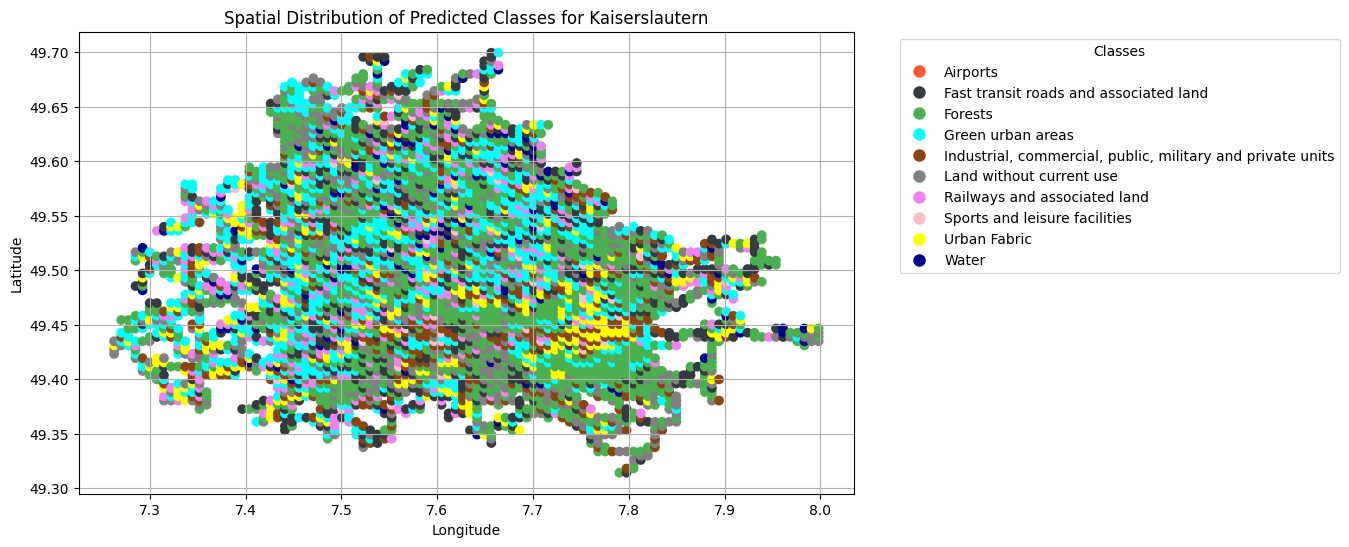

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


# Assuming 'predictions' is a column with lists of probabilities
grid_df['most_likely_class_index'] = grid_df['predictions'].apply(np.argmax)
grid_df['most_likely_class_label'] = grid_df['most_likely_class_index'].map(label2class)


# Colors for each class
colors = [
    '#FF5733',  # Airports - Red
    '#343A40',  # Fast transit roads and associated land - Black
    '#4CAF50',  # Forests - Green
    '#00FFFF',  # Green urban areas - Cyan
    '#8B4513',  # Industrial - Brown
    '#808080',  # Land without current use - Grey
    '#EE82EE',  # Railways and associated land - Violet
    '#FFC0CB',  # Sports and leisure facilities - Pink
    '#FFFF00',  # Urban Fabric - Yellow
    '#00008B'   # Water - Dark Blue
]

# Create a color map
cmap = ListedColormap(colors)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(grid_df['lon'], grid_df['lat'], c=grid_df['most_likely_class_index'], cmap=cmap)
# plt.colorbar(scatter, ticks=range(len(selected_classes)), label='Most Likely Class')
plt.clim(-0.5, len(selected_classes)-0.5)  # Ensure ticks align with class indices

# Create legend
class_patches = [plt.Line2D([0], [0], marker='o', color='w', label=selected_classes[i], markerfacecolor=colors[i], markersize=10) for i in range(len(selected_classes))]
plt.legend(handles=class_patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Predicted Classes for Kaiserslautern')
plt.grid(True)
plt.show()

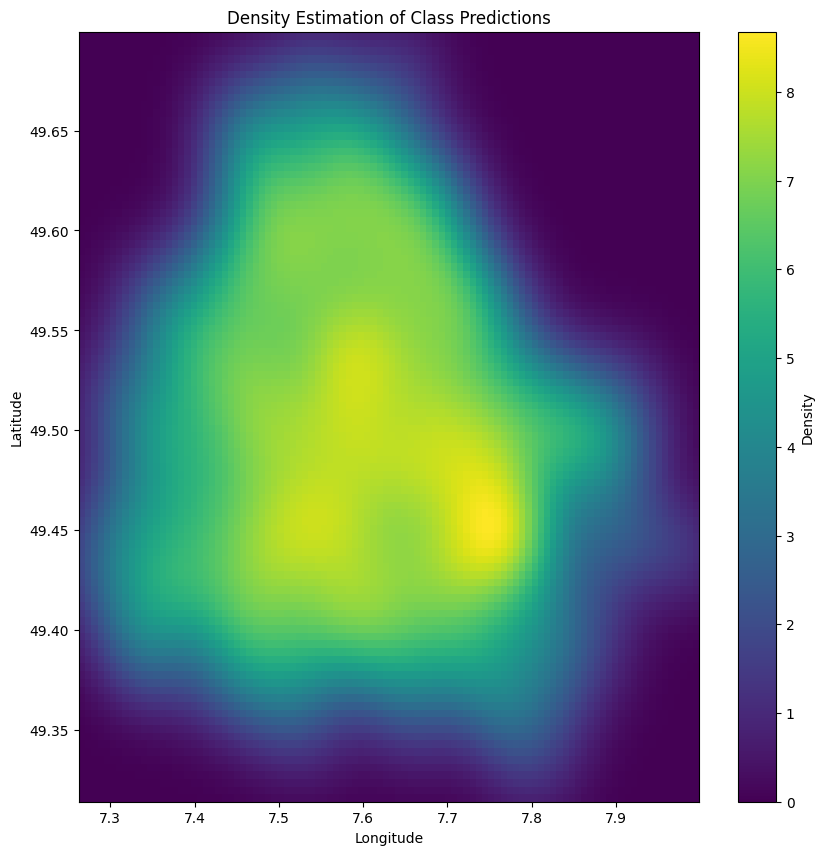

In [58]:
from scipy.stats import gaussian_kde

# Prepare data
data = np.vstack([grid_df['lon'], grid_df['lat']])
kde = gaussian_kde(data, weights=grid_df['most_likely_class_index'])

# Evaluate on a regular grid
lon_lin = np.linspace(grid_df['lon'].min(), grid_df['lon'].max(), 100)
lat_lin = np.linspace(grid_df['lat'].min(), grid_df['lat'].max(), 100)
lon_grid, lat_grid = np.meshgrid(lon_lin, lat_lin)
kde_values = kde(np.vstack([lon_grid.ravel(), lat_grid.ravel()]))

plt.figure(figsize=(10, 10))
plt.imshow(kde_values.reshape(lon_grid.shape), origin='lower', aspect='auto', extent=[lon_lin.min(), lon_lin.max(), lat_lin.min(), lat_lin.max()], cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Density Estimation of Class Predictions')
plt.show()


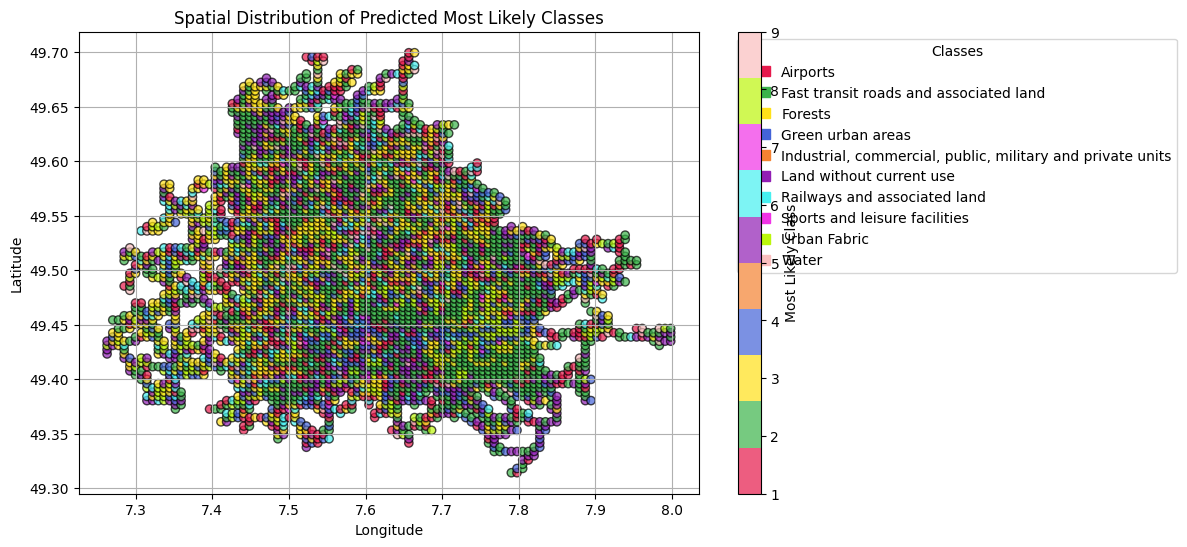

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

grid_df['most_likely_class'] = [np.argmax(pred) for pred in grid_df['predictions']]

colors = [
    '#e6194b', # red
    '#3cb44b', # green
    '#ffe119', # yellow
    '#4363d8', # blue
    '#f58231', # orange
    '#911eb4', # purple
    '#46f0f0', # cyan
    '#f032e6', # magenta
    '#bcf60c', # lime
    '#fabebe'  # pink
]

# Example class names, replace with actual names if available
class_names = [
    'Airports',
    'Fast transit roads and associated land',
    'Forests',
    'Green urban areas',
    'Industrial, commercial, public, military and private units',
    'Land without current use',
    'Railways and associated land',
    'Sports and leisure facilities',
    'Urban Fabric',
    'Water'
]

# Create a custom colormap from the list of colors
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(colors)

# Assuming 'most_likely_class' are indices from 0 to 9
plt.figure(figsize=(10, 6))
sc = plt.scatter(grid_df['lon'], grid_df['lat'], c=grid_df['most_likely_class'], cmap=custom_cmap, edgecolor='k', alpha=0.7)

# Create legend handles
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, class_names)]
plt.legend(handles=legend_handles, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.colorbar(sc, ticks=np.arange(len(class_names)), label='Most Likely Class')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Predicted Most Likely Classes')
plt.grid(True)
plt.show()
